In [1]:
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

findspark.init("/Users/ajaysankarreddychintagunta/spark-3.0.0-preview2-bin-hadoop2.7")

# I was getting the following JVM error while creating a spark session.
# Downgrading the pyspark version to 2.3.2 has resolved the issue.
# https://stackoverflow.com/questions/53161939/pyspark-error-does-not-exist-in-the-jvm-error-when-initializing-sparkcontext

In [2]:
spark = SparkSession.builder.appName('HomeCreditLoanRiskEstimation').getOrCreate()
loan_history_df = spark.read.csv('application_train.csv', header=True, inferSchema=True)

In [3]:
# loan_history_df.printSchema()

In [4]:
# Sk_ID_Curr is the id column which we dont need it in the process #so we get rid of it. 
# And we rename the name of our target variable to "label"

# According to the dataset description, label -> 1 indicates that the loan is NOT paid in time,
# and the label -> 0 indicates that the loan has been repaid well within the time window.

drop_col = ['SK_ID_CURR']
loan_history_df = loan_history_df.select([
    column for column in loan_history_df.columns if column not in drop_col])
loan_history_df = loan_history_df.withColumnRenamed('TARGET', 'label')
# loan_history_df['label'] = 1 - loan_history_df['label'] # Switches the labels of the loan paid status
loan_history_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


Training data shape:  (307511, 121)


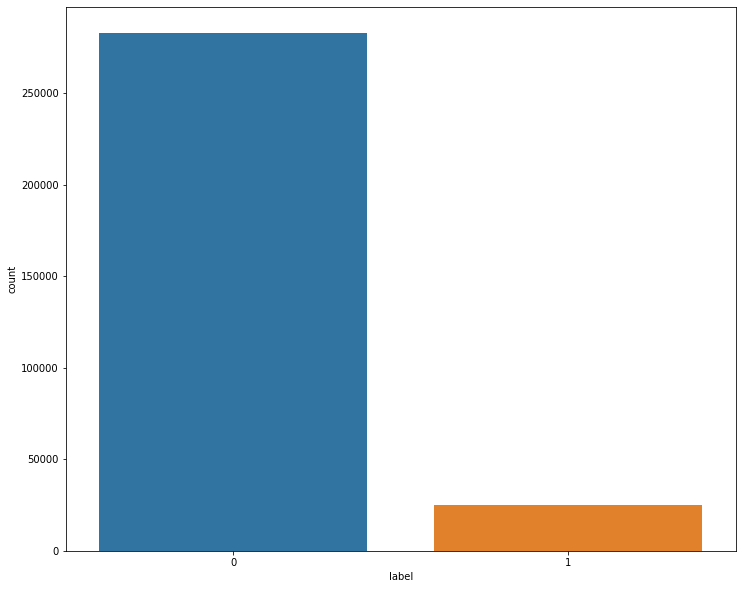

In [5]:
loan_history_df_pandas = loan_history_df.toPandas()
print('Training data shape: ', loan_history_df_pandas.shape)
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=loan_history_df_pandas, order=loan_history_df_pandas['label'].value_counts().index)

<p>
    
    From this information, we see this is an imbalanced class problem. 
    There are far more loans that were repaid on time than loans that were not repaid.

</p>

<p>

    Once we get into more sophisticated machine learning models, we can weight the classes by their representation 
    in the data to reflect this imbalance.
    
</p>

In [6]:
loan_history_df_pandas.head(10)

,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
age_and_loan_df = pd.DataFrame(data={'loan_paid_status': loan_history_df_pandas['label'], 
                                     'age_of_applicant': loan_history_df_pandas['DAYS_BIRTH'] / -365})
age_and_loan_df

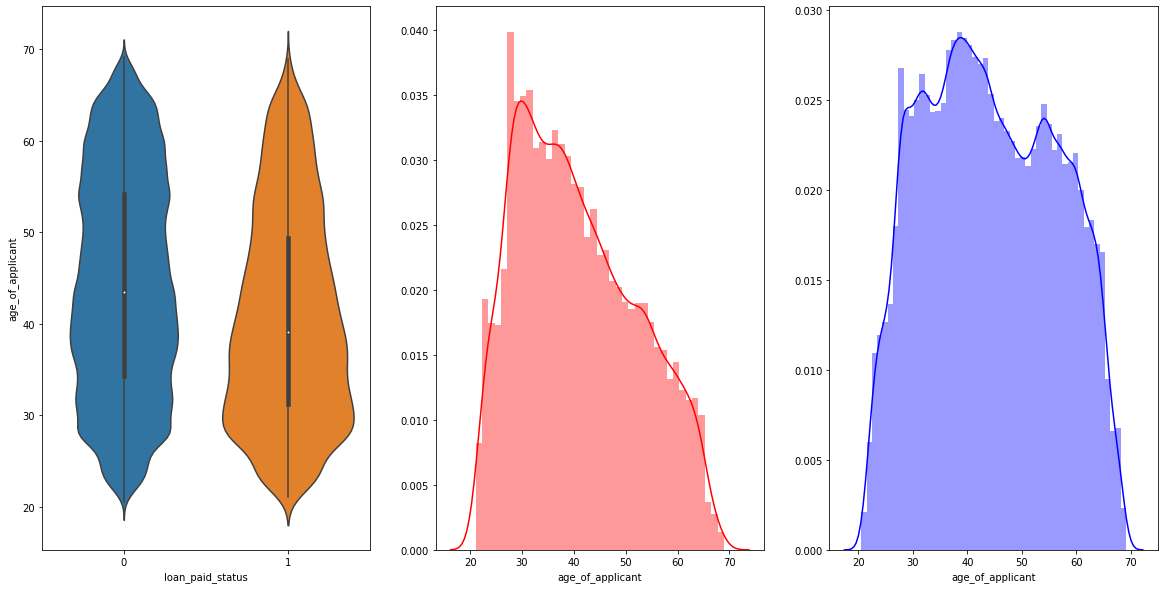

In [9]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.violinplot(x='loan_paid_status', y='age_of_applicant', data=age_and_loan_df)
plt.subplot(1,3,2)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==1]['age_of_applicant'], label='loan_not_paid', 
             color='red')
plt.subplot(1,3,3)
sns.distplot(age_and_loan_df[age_and_loan_df['loan_paid_status']==0]['age_of_applicant'], label='loan_paid', 
             color='blue')